# Нафикова Лиана

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import date, timedelta
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('../train_contest.csv')
test = pd.read_csv('../test_contest.csv')

<Axes: xlabel='target', ylabel='Count'>

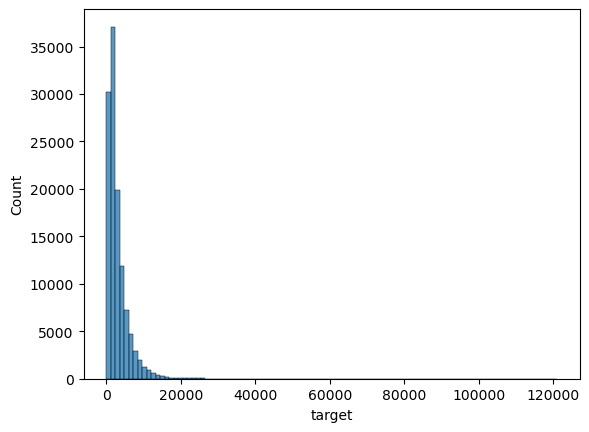

In [ ]:
sns.histplot(train['target'], bins=100)

In [ ]:
features = list(train.drop(['target'], axis=1).columns)

cat_features = []
num_features = []

for feature in features:
    if 'cat' in feature:
        cat_features.append(feature)
    else:
        num_features.append(feature)
for feat in cat_features:
    train[feat] = train[feat].astype('category')
    test[feat] = test[feat].astype('category')

### Генерация признаков (5 баллов)

<Figure size 600x500 with 0 Axes>

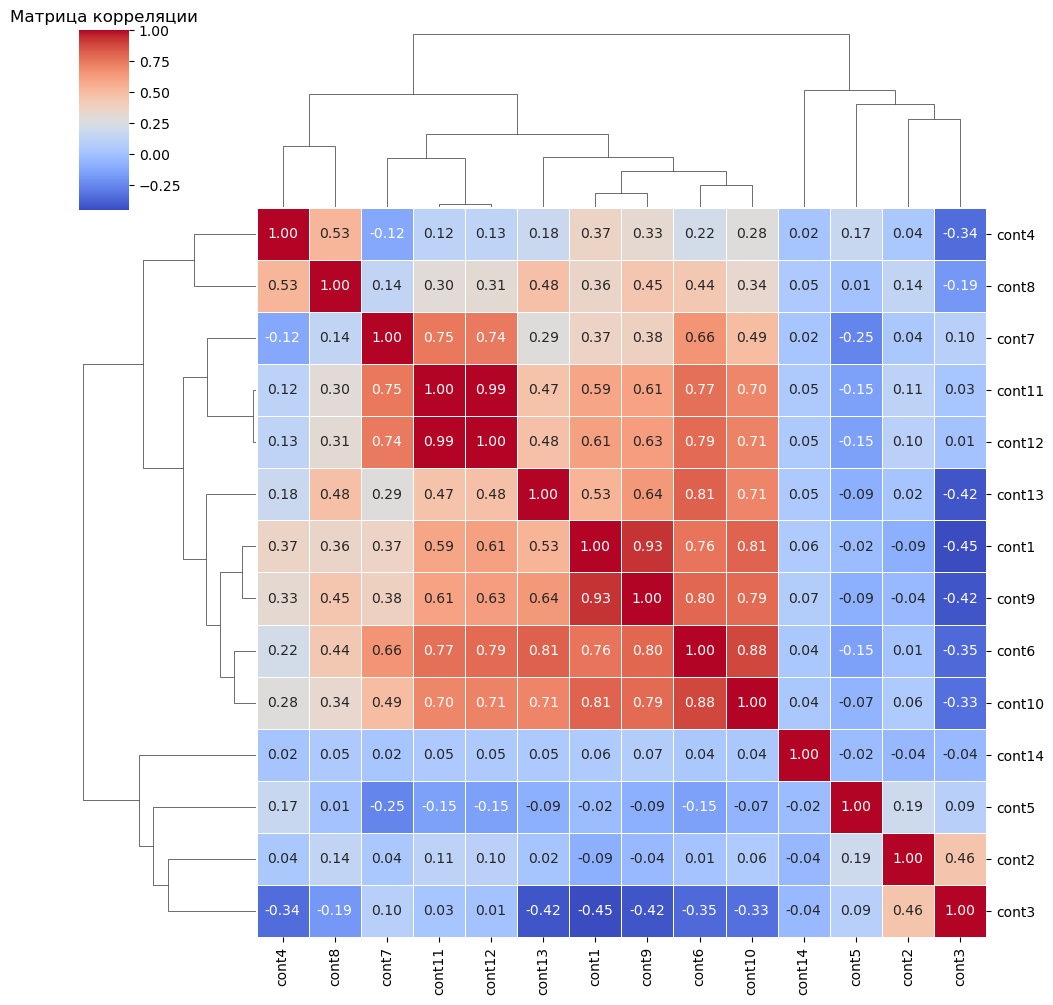

In [ ]:
plt.figure(figsize=(6, 5))
sns.clustermap(train[num_features].corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляции")
plt.show()

Признаки из сильно коррелирующих пар:

In [ ]:
train['new1_cont6_cont10'] = train['cont6'] * train['cont10']
train['new2_cont6_div_cont10'] = train['cont6'] / (train['cont10'] + 1e-6)
train['new3_cont1_cont9'] = train['cont1'] + train['cont9']

test['new1_cont6_cont10'] = test['cont6'] * test['cont10']
test['new2_cont6_div_cont10'] = test['cont6'] / (test['cont10'] + 1e-6)
test['new3_cont1_cont9'] = test['cont1'] + test['cont9']

Признаки на основе топ-2 числовых фичей по значениям shap-values

In [ ]:
train['cont12_plus_cont7'] = train['cont12'] + train['cont7']
train['cont12_minus_cont7'] = train['cont12'] - train['cont7']
train['cont12_times_cont7'] = train['cont12'] * train['cont7']
train['cont12_divided_cont7'] = (train['cont12'] / (train['cont7'] + 1e-6))
train['cont12_squared'] = train['cont12']**2
train['cont7_squared'] = train['cont7']**2

test['cont12_plus_cont7'] = test['cont12'] + test['cont7']
test['cont12_minus_cont7'] = test['cont12'] - test['cont7']
test['cont12_times_cont7'] = test['cont12'] * test['cont7']
test['cont12_divided_cont7'] = (test['cont12'] / (test['cont7'] + 1e-6))
test['cont12_squared'] = test['cont12']**2
test['cont7_squared'] = test['cont7']**2

In [ ]:
num_features = num_features + ['cont12_plus_cont7', 'cont7_squared', 'cont12_minus_cont7', 'cont12_times_cont7', 'cont12_divided_cont7', 'cont12_squared']
features = features + ['cont12_plus_cont7', 'cont7_squared', 'cont12_minus_cont7', 'cont12_times_cont7', 'cont12_divided_cont7', 'cont12_squared']

In [ ]:
num_features = num_features + ['new1_cont6_cont10', 'new2_cont6_div_cont10', 'new3_cont1_cont9']
features = features + ['new1_cont6_cont10', 'new2_cont6_div_cont10', 'new3_cont1_cont9']

cont11 и cont12 очень сильно коррелируют(дублирование информации)

In [ ]:
num_features = [i for i in num_features if i not in  ['cont11']]
features = [i for i in features if i not in  ['cont11'] ]

Разбиение составным категориальных столбцов на раздельные

In [ ]:
import pandas as pd

multi_char_cols = []

for col in train.columns:
    if train[col].dtype == 'object' or isinstance(train[col].dtype, pd.CategoricalDtype):

        unique_values = train[col].astype(str).unique()

        has_multi_char = any(len(str(x)) > 1 for x in unique_values)

        if has_multi_char:
            multi_char_cols.append(col)
            print(f"Найден признак с категориями > 1 символа: {col}")
            print(f"Примеры значений: {unique_values}")
            print(f"Количество уникальных значений: {len(unique_values)}\n")

for col in multi_char_cols:

    max_len = train[col].astype(str).str.len().max()

    for i in range(max_len):
        train[f'{col}_char{i+1}'] = train[col].astype(str).str[i].fillna('None')
        test[f'{col}_char{i+1}'] = test[col].astype(str).str[i].fillna('None')
        cat_features.append(f'{col}_char{i+1}')
        features.append(f'{col}_char{i+1}')
        cat_features = [i for i in cat_features if i != col]
        features = [i for i in features if i != col]


Найден признак с категориями > 1 символа: cat109
Примеры значений: ['BI' 'BU' 'AB' 'K' 'G' 'BO' 'N' 'X' 'AJ' 'AW' 'CI' 'U' 'BQ' 'AS' 'AL' 'M'
 'H' 'AT' 'AR' 'AM' 'CA' 'AF' 'R' 'AH' 'D' 'I' 'BA' 'BX' 'Q' 'BK' 'T' 'CD'
 'E' 'BJ' 'CE' 'O' 'BL' 'AX' 'CL' 'L' 'S' 'F' 'BH' 'AI' 'CC' 'AE' 'AQ'
 'BD' 'BB' 'AP' 'CG' 'AV' 'C' 'AN' 'BE' 'A' 'J' 'CF' 'AY' 'Y' 'BR' 'CK'
 'AU' 'V' 'CJ' 'AA' 'P' 'CH' 'BM' 'BN' 'BG' 'BC' 'ZZ' 'BP' 'B' 'BS' 'BT'
 'AG' 'BF' 'BV' 'BY']
Количество уникальных значений: 81

Найден признак с категориями > 1 символа: cat110
Примеры значений: ['DX' 'CO' 'EB' 'BT' 'EG' 'AP' 'AI' 'CQ' 'CS' 'W' 'EA' 'C' 'CL' 'BC' 'CM'
 'BP' 'T' 'DK' 'AC' 'DW' 'EE' 'EL' 'CR' 'N' 'DL' 'AD' 'CI' 'V' 'CG' 'CJ'
 'BS' 'D' 'BJ' 'DM' 'EF' 'U' 'DH' 'CH' 'AM' 'DU' 'A' 'BG' 'X' 'CY' 'AY'
 'I' 'AA' 'O' 'DJ' 'AK' 'DA' 'AL' 'DY' 'BX' 'CV' 'AB' 'AV' 'EI' 'AW' 'BW'
 'DS' 'EM' 'AR' 'DQ' 'CF' 'K' 'BO' 'E' 'AO' 'BB' 'DI' 'BU' 'CN' 'BA' 'DP'
 'DF' 'DR' 'CU' 'BF' 'CP' 'BR' 'CD' 'AF' 'CK' 'R' 'CW' 'CT' 'L' 'BQ' 'BE'
 

Кодирование буквенных признаков в числа:

In [ ]:
import pandas as pd

def letter_to_num(letter):
    if pd.isna(letter):
        return 0
    try:
        return ord(letter.upper()) - ord('A') + 1
    except:
        return letter

for col in cat_features:
    train[col] = train[col].apply(letter_to_num)
    test[col] = test[col].apply(letter_to_num)


In [ ]:
for feat in cat_features:
    train[feat] = train[feat].astype('category')
    test[feat] = test[feat].astype('category')

In [ ]:
train[cat_features]

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat109_char1,cat109_char2,cat110_char1,cat110_char2,cat112_char1,cat112_char2,cat113_char1,cat113_char2,cat116_char1,cat116_char2
0,2,1,1,2,1,2,1,1,1,1,...,2,9,4,24,25,None,2,13,8,11
1,1,2,1,1,1,1,1,2,2,1,...,2,9,3,15,1,8,13,None,8,11
2,2,2,1,1,1,2,1,1,2,1,...,2,21,5,2,1,19,19,None,12,25
3,1,1,1,2,1,1,1,1,1,1,...,2,9,5,2,11,None,1,19,1,3
4,1,2,1,1,1,1,1,1,2,2,...,2,9,3,15,1,14,13,None,7,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120089,1,2,1,1,1,1,1,1,2,2,...,2,9,5,2,1,14,25,None,9,6
120090,1,2,1,1,1,1,1,1,2,2,...,2,9,2,20,10,None,1,5,7,19
120091,1,2,1,2,2,1,2,2,2,2,...,2,9,3,19,5,None,12,None,12,13
120092,2,2,1,1,1,1,1,1,2,1,...,3,4,5,7,1,11,2,3,4,3


### Построенние модели град. бустинга

Хотелось сохранить распределение таргета:

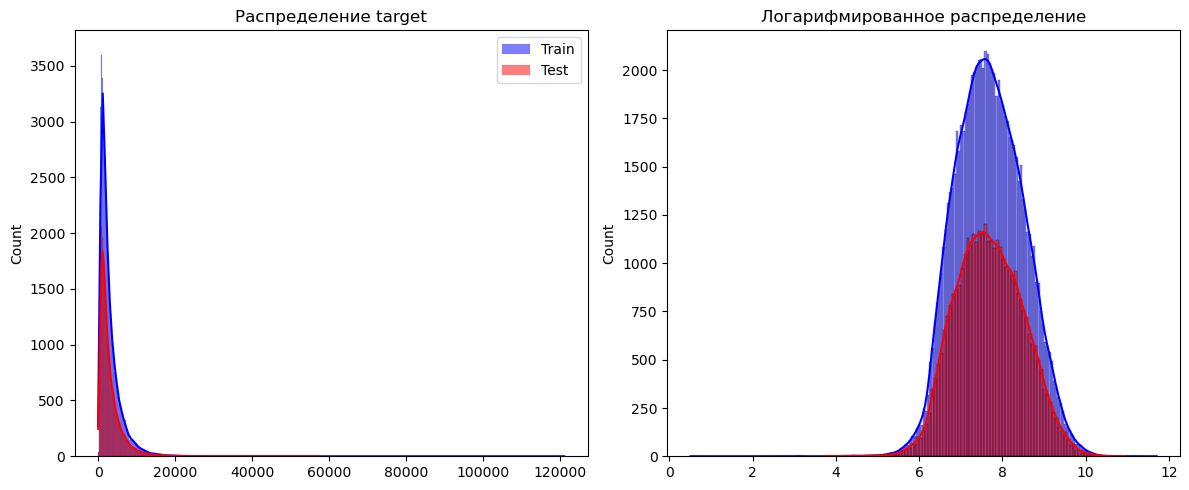

Размеры: train = 84065, test = 36029


In [ ]:
from sklearn.model_selection import train_test_split

target = train['target'].values
train_idx, test_idx = train_test_split(
        np.arange(len(target)),
        test_size=0.3,
        random_state=42
    )

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(target[train_idx], color='blue', kde=True, label='Train')
sns.histplot(target[test_idx], color='red', kde=True, alpha=0.5, label='Test')
plt.title('Распределение target')
plt.tight_layout()
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(target[train_idx]), color='blue', kde=True, label='Train')
sns.histplot(np.log1p(target[test_idx]), color='red', kde=True, alpha=0.5, label='Test')
plt.title('Логарифмированное распределение')
plt.tight_layout()
plt.show()

print(f"Размеры: train = {len(train_idx)}, test = {len(test_idx)}")

In [ ]:
train_set = train.iloc[train_idx].copy()
test_set = train.iloc[test_idx].copy()

In [ ]:
X_train, y_train = train_set[features], target[train_idx]
X_test, y_test = test_set[features], target[test_idx]

In [ ]:
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=cat_features
)

test_data = lgb.Dataset(
    X_test,
    label=y_test,
    categorical_feature=cat_features
)

### Кастомные лоссы/кастомные метрики (5 баллов)

In [ ]:
import numpy as np
from scipy.special import expit

def custom_epsilon_loss_grad_hess(y_raw, true_data=None, y_true=None, alpha=1.2, beta=1., epsilon=1000, p=2):
    """
    Вычисляет градиент и гессиан для пользовательской epsilon-функции потерь.

    Функция потерь имеет разное поведение внутри epsilon-окрестности (линейная часть)
    и за ее пределами (степенная функция). Предусмотрены разные коэффициенты
    для переоценки (overestimation) и недооценки (underestimation).

    Параметры:
    ----------
    y_raw : array-like
        Предсказанные значения (сырые, до преобразования)
    true_data : Dataset, optional
        Объект Dataset из LightGBM (используется если y_true не указан)
    y_true : array-like, optional
        Истинные значения целевой переменной
    alpha : float, default=1.2
        Коэффициент для переоценки (overestimation)
    beta : float, default=1.0
        Коэффициент для недооценки (underestimation)
    epsilon : float, default=1000
        Ширина окрестности, где функция потерь равна 0
    p : float, default=2
        Степень степенной функции за пределами epsilon-окрестности

    Возвращает:
    -----------
    tuple (grad, hess)
        grad : array-like
            Градиент функции потерь
        hess : array-like
            Гессиан функции потерь

    Примечания:
    -----------
    - Для точек внутри epsilon-окрестности (|residual| <= epsilon) градиент и гессиан равны 0
    - Для переоценки (residual > epsilon) используются коэффициенты alpha
    - Для недооценки (residual < -epsilon) используются коэффициенты beta
    """
    if y_true is None:
        y_true = true_data.get_label()

    grad = np.zeros_like(y_true, dtype=np.float64)
    hess = np.zeros_like(y_true, dtype=np.float64)

    residuals = y_raw - y_true

    within_epsilon = np.abs(residuals) <= epsilon
    overestimation = residuals > epsilon
    underestimation = residuals < -epsilon

    grad[within_epsilon] = 0
    grad[overestimation] = alpha * p * (np.abs(residuals[overestimation]) - epsilon)**(p - 1) * np.sign(residuals[overestimation])
    grad[underestimation] = beta * p * (np.abs(residuals[underestimation]) - epsilon)**(p - 1) * np.sign(residuals[underestimation])

    hess[within_epsilon] = 0
    hess[overestimation] = alpha * p * (p - 1) * (np.abs(residuals[overestimation]) - epsilon)**(p - 2)
    hess[underestimation] = beta * p * (p - 1) * (np.abs(residuals[underestimation]) - epsilon)**(p - 2)

    return grad, hess

In [ ]:
def assymetric_metric(predictions, tr, alpha=1.2, beta=0.9, epsilon=100, p=2):
    """
    Вычисляет асимметричную метрику ошибки с epsilon-окрестностью.

    Функция рассчитывает пользовательскую метрику качества, которая:
    - Игнорирует ошибки внутри epsilon-окрестности (|остаток| <= epsilon)
    - Применяет разные весовые коэффициенты для переоценки и недооценки
    - Использует степенную функцию для ошибок за пределами окрестности

    Параметры:
    ----------
    predictions : array-like
        Массив предсказанных значений модели
    tr : lightgbm.Dataset
        Датасет LightGBM, из которого извлекаются истинные значения
    alpha : float, default=1.2
        Коэффициент штрафа для переоценки (overestimation)
    beta : float, default=0.9
        Коэффициент штрафа для недооценки (underestimation)
    epsilon : float, default=100
        Ширина "мертвой зоны", где ошибки не штрафуются
    p : float, default=2
        Степень применяемая к ошибкам

    Возвращает:
    -----------
    tuple (name, metric_value, is_higher_better)
        name : str
            Название метрики ('custom_epsilon_loss')
        metric_value : float
            Значение метрики
        is_higher_better : bool
            Флаг максимизации метрики (False - чем меньше, тем лучше)

    """
    y_true = tr.get_label()
    residuals = predictions - y_true

    within_epsilon = np.abs(residuals) <= epsilon
    overestimation = residuals > epsilon
    underestimation = residuals < -epsilon

    losses = np.zeros_like(y_true)
    losses[overestimation] = alpha * (np.abs(residuals[overestimation]) - epsilon)**p
    losses[underestimation] = beta * (np.abs(residuals[underestimation]) - epsilon)**p

    metric_value = np.sqrt(np.mean(losses))

    return 'custom_epsilon_loss', metric_value, False

In [ ]:
params = {
    'objective': custom_epsilon_loss_grad_hess,
    'boosting_type': 'gbdt',
    'num_trees': 160,
    'max_depth': 7,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'metric': None,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}

model = lgb.train(
    train_set= train_data,
    valid_sets= [train_data, test_data],
    valid_names= ['train', 'test'],
    feval=assymetric_metric,
    callbacks= [
        lgb.log_evaluation(period=5)
    ],
    params=params
)

[5]	train's custom_epsilon_loss: 2940.36	test's custom_epsilon_loss: 2902.41
[10]	train's custom_epsilon_loss: 2324.7	test's custom_epsilon_loss: 2295.36
[15]	train's custom_epsilon_loss: 2031.39	test's custom_epsilon_loss: 2009.66
[20]	train's custom_epsilon_loss: 1906.58	test's custom_epsilon_loss: 1893.12
[25]	train's custom_epsilon_loss: 1844.3	test's custom_epsilon_loss: 1844.55
[30]	train's custom_epsilon_loss: 1806.38	test's custom_epsilon_loss: 1818.15
[35]	train's custom_epsilon_loss: 1779.31	test's custom_epsilon_loss: 1802.49
[40]	train's custom_epsilon_loss: 1759.86	test's custom_epsilon_loss: 1793.76
[45]	train's custom_epsilon_loss: 1741.57	test's custom_epsilon_loss: 1783.32
[50]	train's custom_epsilon_loss: 1726.47	test's custom_epsilon_loss: 1777.14
[55]	train's custom_epsilon_loss: 1713.09	test's custom_epsilon_loss: 1767.68
[60]	train's custom_epsilon_loss: 1700.22	test's custom_epsilon_loss: 1762.24
[65]	train's custom_epsilon_loss: 1688.4	test's custom_epsilon_loss

### Интерпретация построенных моделей град. бустинга (5 баллов)

Text(0, 0.5, 'model prediction')

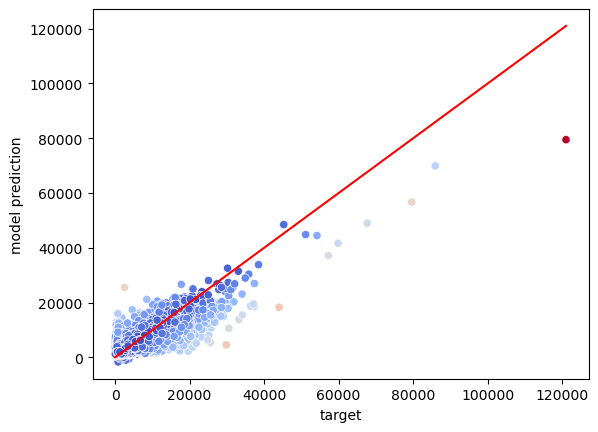

In [ ]:
y_pred_val_raw = model.predict(train[features])
y_val = train.target
sns.scatterplot(x=y_val, y=y_pred_val_raw, c=np.abs(y_val - y_pred_val_raw), cmap='coolwarm')
sns.lineplot(x=y_val, y=y_val, color='red')
plt.ylabel('model prediction')

Модель сильно недооценивала объекты с большим значением таргета. Имело смысл поменять параметры в лоссе
так как alpha - коэффициент штрафа за переоценку (когда модель предсказывает значение значительно выше истинного).
beta - коэффициент штрафа за недооценку (когда модель предсказывает значение значительно ниже истинного).

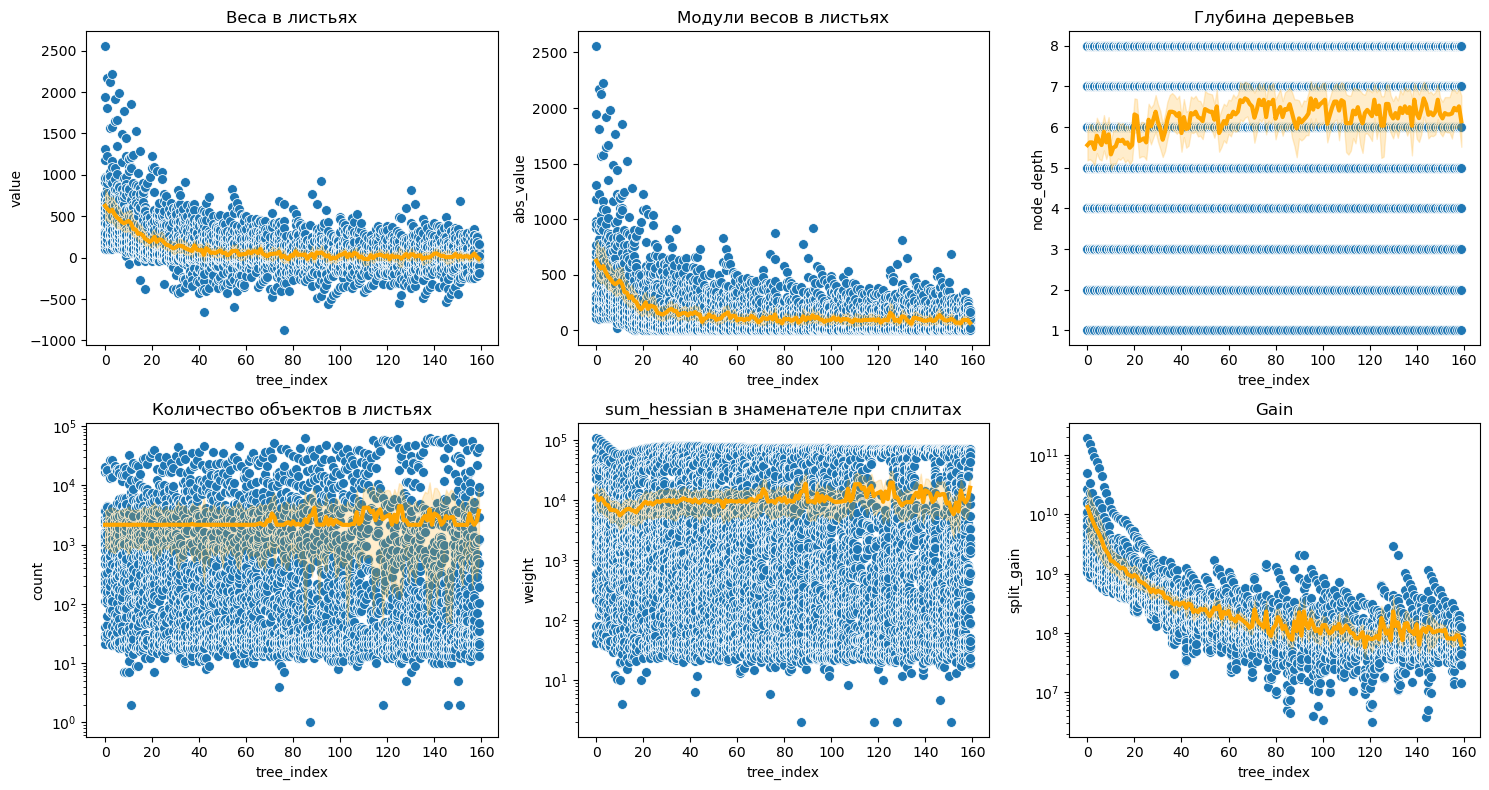

In [ ]:
from utils import *
t = model.trees_to_dataframe()
plot_ensemble_profile(t)

gain не успевал стабилизироваться за 100 деревьев. Поэтому увеличила.

/tmp/ipykernel_1412284/337821896.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  t_prep = t_prep.pivot_table(values='cnt', columns='node_depth', index='split_feature')


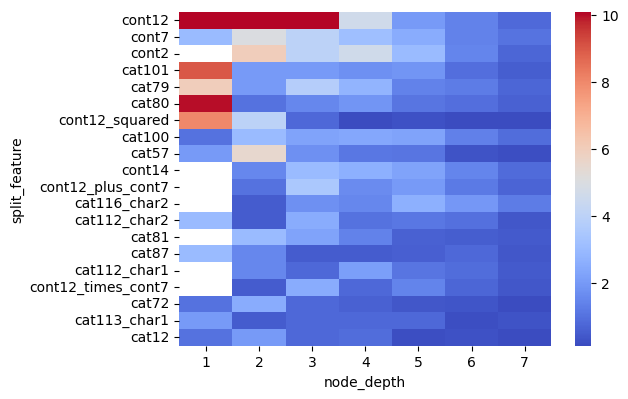

In [ ]:
plot_feature_depth(t, top_k=20)

Начиная с 7 глубины, многие признаки уже совсем почти не использовались. Сделала глубину деревьев 7

### Понижение размерности (5 баллов) и Кластеризация (5 баллов)

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(train[features])

Сгенерировала новые признаки на основе cont12 и cont7, так как они самым высоким значением shap. Для удобства перекодировала категориальные признаки в числовые.

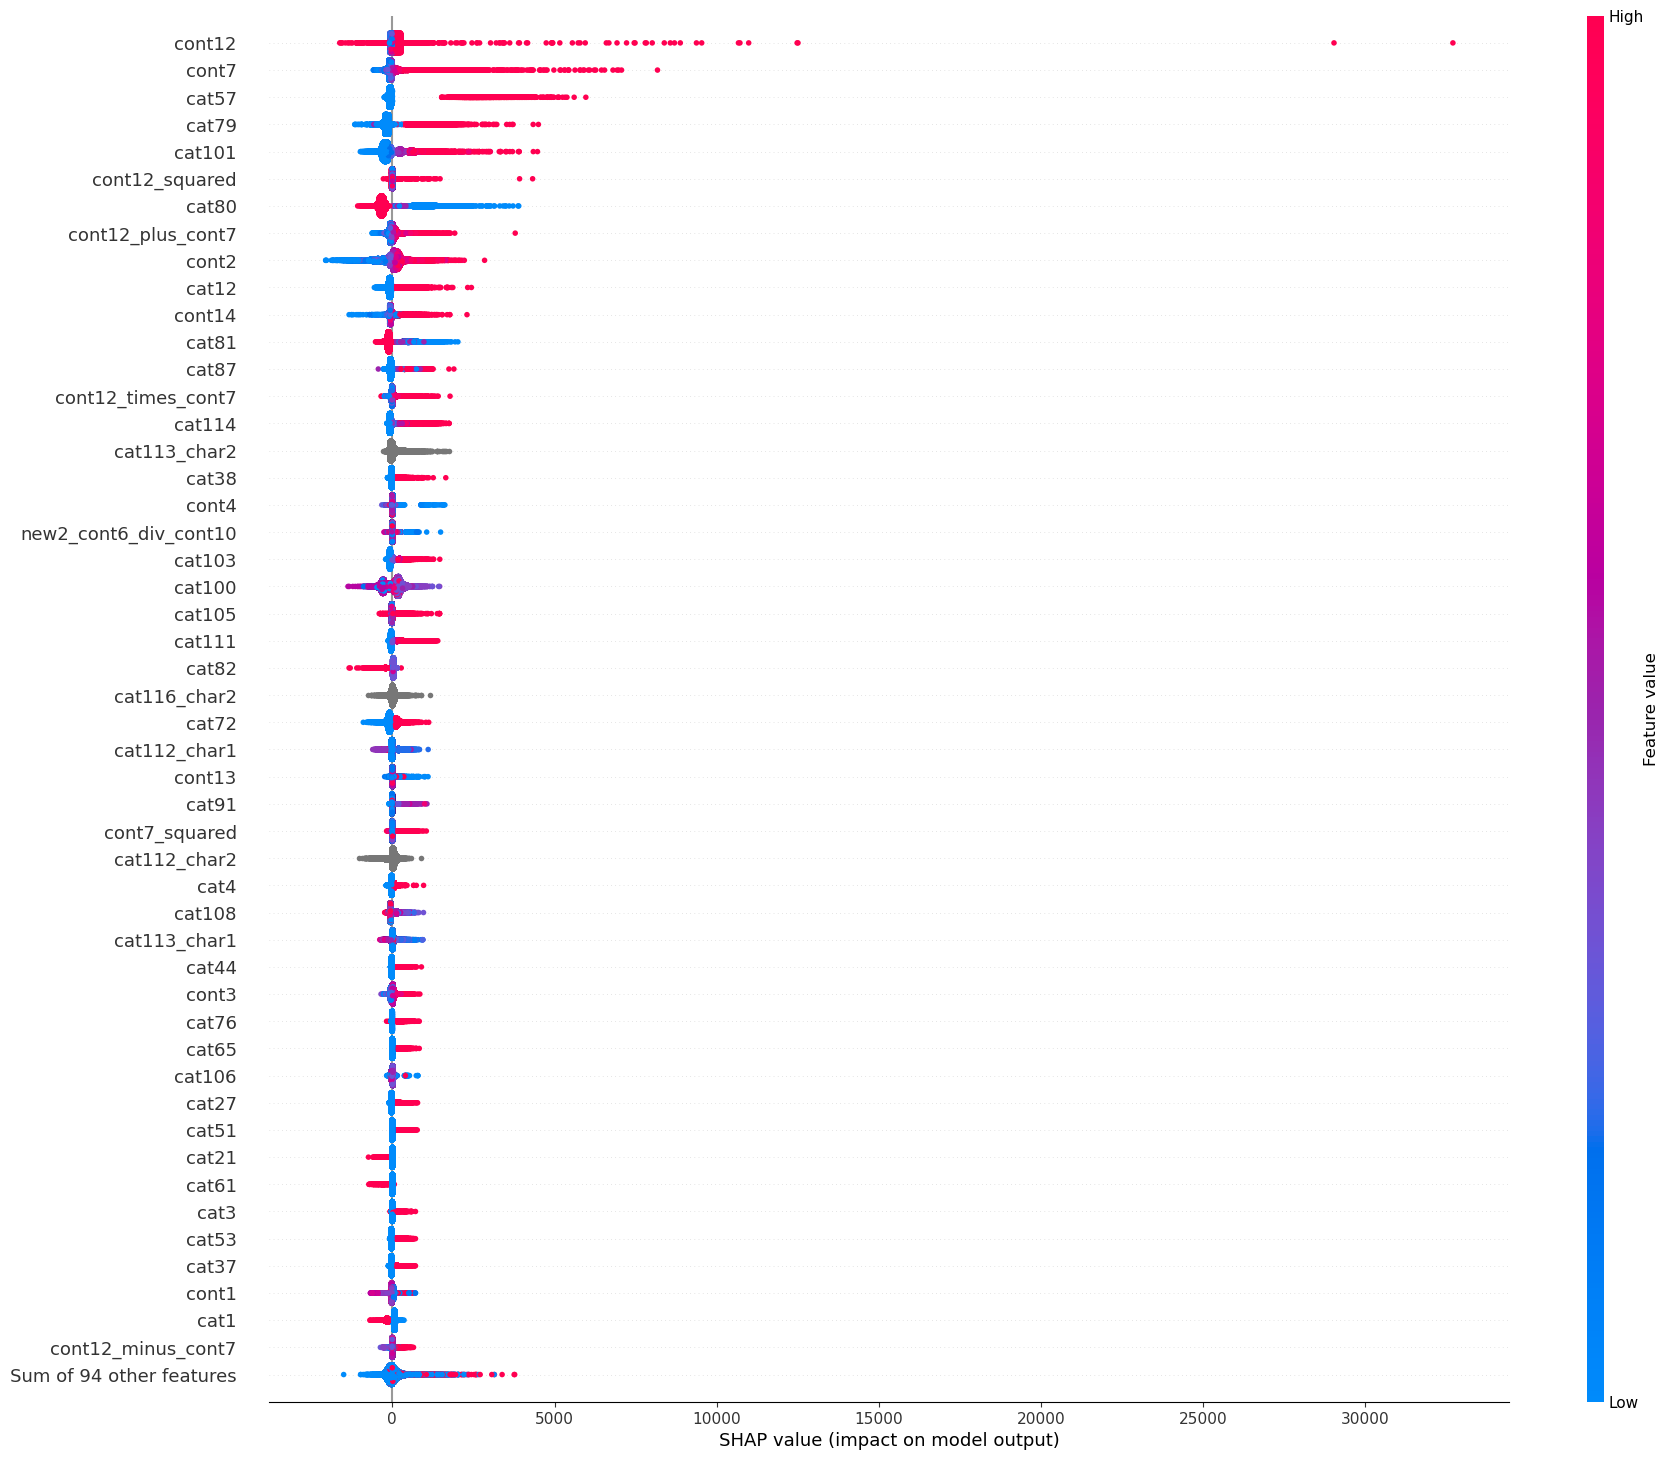

In [ ]:
shap.plots.beeswarm(shap_values, max_display=50, order=shap.Explanation.abs.max(0), plot_size=(20, 18))

In [ ]:
import plotly.express as px
import umap

2025-05-06 08:23:16.953856: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 08:23:16.999581: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-06 08:23:17.783902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
mapper = umap.UMAP(n_jobs=-1, n_neighbors=50, metric='euclidean')
emb = mapper.fit_transform(shap_values.values)

In [ ]:
embs = pd.DataFrame({
    'x': emb[:, 0],
    'y': emb[:, 1],
    'color': train.target > 30000,
})
fig = px.scatter(data_frame=embs, x='x', y='y', color='color')
fig.update_layout(width=800)

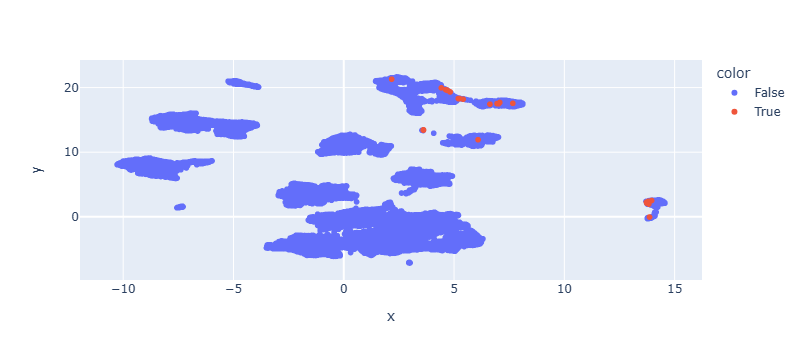

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/AIMasters/ML2/MysteriousCompetition/newplot (3).png')

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=2500, prediction_data=True)
train_clusters = clusterer.fit_predict(emb)
train['shap_cluster'] = train_clusters

In [ ]:
embs = pd.DataFrame({
    'x': emb[:, 0],
    'y': emb[:, 1],
    'color': train_clusters
})
fig = px.scatter(data_frame=embs, x='x', y='y', color='color')
fig.update_layout(width=800)

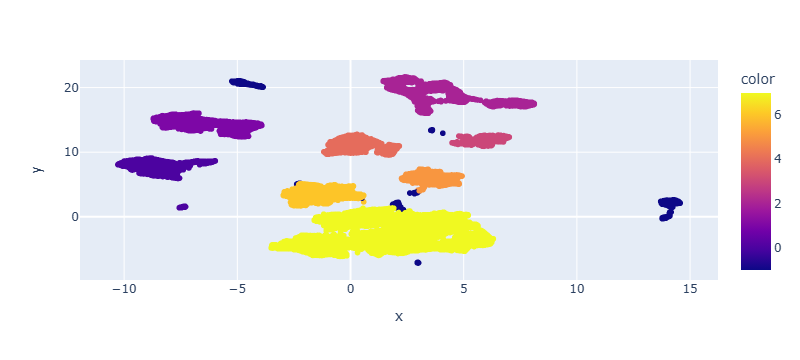

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/AIMasters/ML2/MysteriousCompetition/newplot (2).png')

Сгенерировала признак на основе кластеров и cont12

In [ ]:
train_cluster_means = train.groupby('shap_cluster')['cont12'].mean().to_dict()
train['cont12_cluster_mean'] = train['shap_cluster'].map(train_cluster_means)

In [ ]:
test_shap_values = explainer(test[features])
test_emb = mapper.transform(test_shap_values.values)
test_clusters = hdbscan.approximate_predict(clusterer, test_emb)
test['shap_cluster'] = test_clusters[0]

test_cluster_means = test.groupby('shap_cluster')['cont12'].mean().to_dict()
test['cont12_cluster_mean'] = test['shap_cluster'].map(test_cluster_means)
features.append('cont12_cluster_mean')
cat_features.append('cont12_cluster_mean')

### Тюнинг гиперпараметров бустинга (5 баллов)

In [ ]:
target = train['target'].values
train_idx, test_idx = train_test_split(
        np.arange(len(target)),
        test_size=0.3,
        random_state=42
    )

train_set = train.iloc[train_idx].copy()
test_set = train.iloc[test_idx].copy()

In [ ]:
X_train, y_train = train_set[features], target[train_idx]
X_test, y_test = test_set[features], target[test_idx]

In [ ]:
lgb_train = lgb.Dataset(
    train[features],
    label=train['target'],
    categorical_feature=cat_features
)

In [ ]:
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=cat_features
)

test_data = lgb.Dataset(
    X_test,
    label=y_test,
    categorical_feature=cat_features
)

In [ ]:
import optuna

def objective(trial):
    params = {
    'objective': custom_epsilon_loss_grad_hess,
    'boosting_type': 'gbdt',
    'num_trees': 160,
    'max_depth': 7,
    'min_data_in_leaf': 20,
    'metric': None,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_leaves': trial.suggest_int('num_leaves', 25, 35),
    'verbose': -1
    }

    model = lgb.train(
        train_set= train_data,
        valid_sets= [train_data, test_data],
        valid_names= ['train', 'test'],
        feval=assymetric_metric,
        callbacks= [
            lgb.log_evaluation(period=5),
            lgb.early_stopping(10)
        ],
        params=params
    )

    preds = model.predict(X_test)
    metric = assymetric_metric(preds, test_data)[1]
    return metric

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-06 08:50:18,738] A new study created in memory with name: no-name-23259fbd-09fc-494e-8c44-796eb5f43a19


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2939.06	test's custom_epsilon_loss: 2901.4
[10]	train's custom_epsilon_loss: 2320.37	test's custom_epsilon_loss: 2292.49
[15]	train's custom_epsilon_loss: 2024.89	test's custom_epsilon_loss: 2007.2
[20]	train's custom_epsilon_loss: 1898.32	test's custom_epsilon_loss: 1890.6
[25]	train's custom_epsilon_loss: 1835.29	test's custom_epsilon_loss: 1840.9
[30]	train's custom_epsilon_loss: 1797.39	test's custom_epsilon_loss: 1815.06
[35]	train's custom_epsilon_loss: 1770.82	test's custom_epsilon_loss: 1800.87
[40]	train's custom_epsilon_loss: 1752.06	test's custom_epsilon_loss: 1792.38
[45]	train's custom_epsilon_loss: 1732.26	test's custom_epsilon_loss: 1781.46
[50]	train's custom_epsilon_loss: 1717.08	test's custom_epsilon_loss: 1775.79
[55]	train's custom_epsilon_loss: 1703.97	test's custom_epsilon_loss: 1766.79
[60]	train's custom_epsilon_loss: 1691.7	test's custom_epsilon_loss: 1760.87
[65]	trai

[I 2025-05-06 08:50:22,410] Trial 0 finished with value: 1741.3056640625 and parameters: {'num_leaves': 34}. Best is trial 0 with value: 1741.3056640625.


[105]	train's custom_epsilon_loss: 1623.62	test's custom_epsilon_loss: 1741.51
[110]	train's custom_epsilon_loss: 1619.47	test's custom_epsilon_loss: 1742.1
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1631.17	test's custom_epsilon_loss: 1741.31
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2940.36	test's custom_epsilon_loss: 2902.41
[10]	train's custom_epsilon_loss: 2324.7	test's custom_epsilon_loss: 2295.36
[15]	train's custom_epsilon_loss: 2031.39	test's custom_epsilon_loss: 2009.66
[20]	train's custom_epsilon_loss: 1906.58	test's custom_epsilon_loss: 1893.12
[25]	train's custom_epsilon_loss: 1844.3	test's custom_epsilon_loss: 1844.55
[30]	train's custom_epsilon_loss: 1806.38	test's custom_epsilon_loss: 1818.15
[35]	train's custom_epsilon_loss: 1779.31	test's custom_epsilon_loss: 1802.49
[40]	train's custom_epsilon_loss: 1759.86	test's custom_epsilon_loss: 1793.76
[45]	train's custom_epsilon_loss: 1741.57	test'

[I 2025-05-06 08:50:25,354] Trial 1 finished with value: 1739.1888427734375 and parameters: {'num_leaves': 31}. Best is trial 1 with value: 1739.1888427734375.


Early stopping, best iteration is:
[103]	train's custom_epsilon_loss: 1631.57	test's custom_epsilon_loss: 1739.19
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.23	test's custom_epsilon_loss: 2902.93
[10]	train's custom_epsilon_loss: 2326.12	test's custom_epsilon_loss: 2298.17
[15]	train's custom_epsilon_loss: 2032.21	test's custom_epsilon_loss: 2012.03
[20]	train's custom_epsilon_loss: 1908.91	test's custom_epsilon_loss: 1895.93
[25]	train's custom_epsilon_loss: 1846.46	test's custom_epsilon_loss: 1847.04
[30]	train's custom_epsilon_loss: 1808.16	test's custom_epsilon_loss: 1819.97
[35]	train's custom_epsilon_loss: 1779.44	test's custom_epsilon_loss: 1804.16
[40]	train's custom_epsilon_loss: 1759.19	test's custom_epsilon_loss: 1793.17
[45]	train's custom_epsilon_loss: 1740.46	test's custom_epsilon_loss: 1782.62
[50]	train's custom_epsilon_loss: 1724.54	test's custom_epsilon_loss: 1774.09
[55]	train's custom_epsilon_loss: 1712.28	test

[I 2025-05-06 08:50:27,609] Trial 2 finished with value: 1741.623291015625 and parameters: {'num_leaves': 30}. Best is trial 1 with value: 1739.1888427734375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2938.43	test's custom_epsilon_loss: 2900.84
[10]	train's custom_epsilon_loss: 2320.09	test's custom_epsilon_loss: 2293.96
[15]	train's custom_epsilon_loss: 2023.74	test's custom_epsilon_loss: 2007.6
[20]	train's custom_epsilon_loss: 1897.74	test's custom_epsilon_loss: 1890.42
[25]	train's custom_epsilon_loss: 1833.79	test's custom_epsilon_loss: 1840.76
[30]	train's custom_epsilon_loss: 1796.03	test's custom_epsilon_loss: 1815.67
[35]	train's custom_epsilon_loss: 1768.11	test's custom_epsilon_loss: 1801.51
[40]	train's custom_epsilon_loss: 1748.14	test's custom_epsilon_loss: 1790.13
[45]	train's custom_epsilon_loss: 1729.11	test's custom_epsilon_loss: 1779.64
[50]	train's custom_epsilon_loss: 1713.77	test's custom_epsilon_loss: 1773.54
[55]	train's custom_epsilon_loss: 1701.76	test's custom_epsilon_loss: 1765.45
[60]	train's custom_epsilon_loss: 1690.83	test's custom_epsilon_loss: 1760.31
[65]	

[I 2025-05-06 08:50:30,283] Trial 3 finished with value: 1744.362548828125 and parameters: {'num_leaves': 35}. Best is trial 1 with value: 1739.1888427734375.


[110]	train's custom_epsilon_loss: 1616.86	test's custom_epsilon_loss: 1744.72
Early stopping, best iteration is:
[103]	train's custom_epsilon_loss: 1624.73	test's custom_epsilon_loss: 1744.36
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2939.06	test's custom_epsilon_loss: 2901.4
[10]	train's custom_epsilon_loss: 2320.37	test's custom_epsilon_loss: 2292.49
[15]	train's custom_epsilon_loss: 2024.89	test's custom_epsilon_loss: 2007.2
[20]	train's custom_epsilon_loss: 1898.32	test's custom_epsilon_loss: 1890.6
[25]	train's custom_epsilon_loss: 1835.29	test's custom_epsilon_loss: 1840.9
[30]	train's custom_epsilon_loss: 1797.39	test's custom_epsilon_loss: 1815.06
[35]	train's custom_epsilon_loss: 1770.82	test's custom_epsilon_loss: 1800.87
[40]	train's custom_epsilon_loss: 1752.06	test's custom_epsilon_loss: 1792.38
[45]	train's custom_epsilon_loss: 1732.26	test's custom_epsilon_loss: 1781.46
[50]	train's custom_epsilon_loss: 1717.08	test's 

[I 2025-05-06 08:50:32,819] Trial 4 finished with value: 1741.3056640625 and parameters: {'num_leaves': 34}. Best is trial 1 with value: 1739.1888427734375.


[105]	train's custom_epsilon_loss: 1623.62	test's custom_epsilon_loss: 1741.51
[110]	train's custom_epsilon_loss: 1619.47	test's custom_epsilon_loss: 1742.1
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1631.17	test's custom_epsilon_loss: 1741.31
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2944.91	test's custom_epsilon_loss: 2907.38
[10]	train's custom_epsilon_loss: 2331.17	test's custom_epsilon_loss: 2303.58
[15]	train's custom_epsilon_loss: 2038.7	test's custom_epsilon_loss: 2017.15
[20]	train's custom_epsilon_loss: 1919.37	test's custom_epsilon_loss: 1906.24
[25]	train's custom_epsilon_loss: 1857.09	test's custom_epsilon_loss: 1855.64
[30]	train's custom_epsilon_loss: 1819.58	test's custom_epsilon_loss: 1828.23
[35]	train's custom_epsilon_loss: 1791.04	test's custom_epsilon_loss: 1809.98
[40]	train's custom_epsilon_loss: 1771.21	test's custom_epsilon_loss: 1799.1
[45]	train's custom_epsilon_loss: 1751.79	test'

[I 2025-05-06 08:50:35,842] Trial 5 finished with value: 1742.815185546875 and parameters: {'num_leaves': 26}. Best is trial 1 with value: 1739.1888427734375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2940.36	test's custom_epsilon_loss: 2902.41
[10]	train's custom_epsilon_loss: 2324.7	test's custom_epsilon_loss: 2295.36
[15]	train's custom_epsilon_loss: 2031.39	test's custom_epsilon_loss: 2009.66
[20]	train's custom_epsilon_loss: 1906.58	test's custom_epsilon_loss: 1893.12
[25]	train's custom_epsilon_loss: 1844.3	test's custom_epsilon_loss: 1844.55
[30]	train's custom_epsilon_loss: 1806.38	test's custom_epsilon_loss: 1818.15
[35]	train's custom_epsilon_loss: 1779.31	test's custom_epsilon_loss: 1802.49
[40]	train's custom_epsilon_loss: 1759.86	test's custom_epsilon_loss: 1793.76
[45]	train's custom_epsilon_loss: 1741.57	test's custom_epsilon_loss: 1783.32
[50]	train's custom_epsilon_loss: 1726.47	test's custom_epsilon_loss: 1777.14
[55]	train's custom_epsilon_loss: 1713.09	test's custom_epsilon_loss: 1767.68
[60]	train's custom_epsilon_loss: 1700.22	test's custom_epsilon_loss: 1762.24
[65]	t

[I 2025-05-06 08:50:38,745] Trial 6 finished with value: 1739.1888427734375 and parameters: {'num_leaves': 31}. Best is trial 1 with value: 1739.1888427734375.


Early stopping, best iteration is:
[103]	train's custom_epsilon_loss: 1631.57	test's custom_epsilon_loss: 1739.19
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2938.92	test's custom_epsilon_loss: 2901.75
[10]	train's custom_epsilon_loss: 2322.62	test's custom_epsilon_loss: 2295.94
[15]	train's custom_epsilon_loss: 2027.43	test's custom_epsilon_loss: 2007.87
[20]	train's custom_epsilon_loss: 1903.05	test's custom_epsilon_loss: 1891.78
[25]	train's custom_epsilon_loss: 1838.28	test's custom_epsilon_loss: 1841.9
[30]	train's custom_epsilon_loss: 1801.12	test's custom_epsilon_loss: 1817.22
[35]	train's custom_epsilon_loss: 1775.22	test's custom_epsilon_loss: 1803.86
[40]	train's custom_epsilon_loss: 1757.29	test's custom_epsilon_loss: 1797.04
[45]	train's custom_epsilon_loss: 1736.56	test's custom_epsilon_loss: 1787
[50]	train's custom_epsilon_loss: 1720.63	test's custom_epsilon_loss: 1779.91
[55]	train's custom_epsilon_loss: 1707.1	test's cu

[I 2025-05-06 08:50:40,913] Trial 7 finished with value: 1744.12353515625 and parameters: {'num_leaves': 33}. Best is trial 1 with value: 1739.1888427734375.


Early stopping, best iteration is:
[103]	train's custom_epsilon_loss: 1626.19	test's custom_epsilon_loss: 1744.12
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.23	test's custom_epsilon_loss: 2902.93
[10]	train's custom_epsilon_loss: 2326.12	test's custom_epsilon_loss: 2298.17
[15]	train's custom_epsilon_loss: 2032.21	test's custom_epsilon_loss: 2012.03
[20]	train's custom_epsilon_loss: 1908.91	test's custom_epsilon_loss: 1895.93
[25]	train's custom_epsilon_loss: 1846.46	test's custom_epsilon_loss: 1847.04
[30]	train's custom_epsilon_loss: 1808.16	test's custom_epsilon_loss: 1819.97
[35]	train's custom_epsilon_loss: 1779.44	test's custom_epsilon_loss: 1804.16
[40]	train's custom_epsilon_loss: 1759.19	test's custom_epsilon_loss: 1793.17
[45]	train's custom_epsilon_loss: 1740.46	test's custom_epsilon_loss: 1782.62
[50]	train's custom_epsilon_loss: 1724.54	test's custom_epsilon_loss: 1774.09
[55]	train's custom_epsilon_loss: 1712.28	test

[I 2025-05-06 08:50:43,512] Trial 8 finished with value: 1741.623291015625 and parameters: {'num_leaves': 30}. Best is trial 1 with value: 1739.1888427734375.


[110]	train's custom_epsilon_loss: 1623.91	test's custom_epsilon_loss: 1741.87
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1636.54	test's custom_epsilon_loss: 1741.62
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	test's custom_epsilon_loss: 1780.75
[50]	train's custom_epsilon_loss: 1727.88	test

[I 2025-05-06 08:50:46,156] Trial 9 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


[105]	train's custom_epsilon_loss: 1635.45	test's custom_epsilon_loss: 1738.34
[110]	train's custom_epsilon_loss: 1630.03	test's custom_epsilon_loss: 1738.06
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1642.94	test's custom_epsilon_loss: 1737.59
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2944.91	test's custom_epsilon_loss: 2907.38
[10]	train's custom_epsilon_loss: 2331.17	test's custom_epsilon_loss: 2303.58
[15]	train's custom_epsilon_loss: 2038.7	test's custom_epsilon_loss: 2017.15
[20]	train's custom_epsilon_loss: 1919.37	test's custom_epsilon_loss: 1906.24
[25]	train's custom_epsilon_loss: 1857.09	test's custom_epsilon_loss: 1855.64
[30]	train's custom_epsilon_loss: 1819.58	test's custom_epsilon_loss: 1828.23
[35]	train's custom_epsilon_loss: 1791.04	test's custom_epsilon_loss: 1809.98
[40]	train's custom_epsilon_loss: 1771.21	test's custom_epsilon_loss: 1799.1
[45]	train's custom_epsilon_loss: 1751.79	test

[I 2025-05-06 08:50:48,690] Trial 10 finished with value: 1742.815185546875 and parameters: {'num_leaves': 26}. Best is trial 9 with value: 1737.589599609375.


[110]	train's custom_epsilon_loss: 1635.54	test's custom_epsilon_loss: 1743.66
Early stopping, best iteration is:
[103]	train's custom_epsilon_loss: 1642.5	test's custom_epsilon_loss: 1742.82
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2943.08	test's custom_epsilon_loss: 2904.95
[10]	train's custom_epsilon_loss: 2328.17	test's custom_epsilon_loss: 2297.85
[15]	train's custom_epsilon_loss: 2036.16	test's custom_epsilon_loss: 2013.53
[20]	train's custom_epsilon_loss: 1913.75	test's custom_epsilon_loss: 1899.96
[25]	train's custom_epsilon_loss: 1850.85	test's custom_epsilon_loss: 1849.69
[30]	train's custom_epsilon_loss: 1814.22	test's custom_epsilon_loss: 1824.61
[35]	train's custom_epsilon_loss: 1787.14	test's custom_epsilon_loss: 1809.53
[40]	train's custom_epsilon_loss: 1766.97	test's custom_epsilon_loss: 1799.39
[45]	train's custom_epsilon_loss: 1747.68	test's custom_epsilon_loss: 1789.56
[50]	train's custom_epsilon_loss: 1732.85	test

[I 2025-05-06 08:50:50,992] Trial 11 finished with value: 1744.136962890625 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 1737.589599609375.


Early stopping, best iteration is:
[106]	train's custom_epsilon_loss: 1636.45	test's custom_epsilon_loss: 1744.14
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2943.08	test's custom_epsilon_loss: 2904.95
[10]	train's custom_epsilon_loss: 2328.17	test's custom_epsilon_loss: 2297.85
[15]	train's custom_epsilon_loss: 2036.16	test's custom_epsilon_loss: 2013.53
[20]	train's custom_epsilon_loss: 1913.75	test's custom_epsilon_loss: 1899.96
[25]	train's custom_epsilon_loss: 1850.85	test's custom_epsilon_loss: 1849.69
[30]	train's custom_epsilon_loss: 1814.22	test's custom_epsilon_loss: 1824.61
[35]	train's custom_epsilon_loss: 1787.14	test's custom_epsilon_loss: 1809.53
[40]	train's custom_epsilon_loss: 1766.97	test's custom_epsilon_loss: 1799.39
[45]	train's custom_epsilon_loss: 1747.68	test's custom_epsilon_loss: 1789.56
[50]	train's custom_epsilon_loss: 1732.85	test's custom_epsilon_loss: 1782.33
[55]	train's custom_epsilon_loss: 1720.64	test

[I 2025-05-06 08:50:53,738] Trial 12 finished with value: 1744.136962890625 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 1737.589599609375.


[110]	train's custom_epsilon_loss: 1632.1	test's custom_epsilon_loss: 1744.88
[115]	train's custom_epsilon_loss: 1628.41	test's custom_epsilon_loss: 1745.41
Early stopping, best iteration is:
[106]	train's custom_epsilon_loss: 1636.45	test's custom_epsilon_loss: 1744.14
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2939.13	test's custom_epsilon_loss: 2902.29
[10]	train's custom_epsilon_loss: 2323.22	test's custom_epsilon_loss: 2297.36
[15]	train's custom_epsilon_loss: 2026.36	test's custom_epsilon_loss: 2008.09
[20]	train's custom_epsilon_loss: 1902.77	test's custom_epsilon_loss: 1893.66
[25]	train's custom_epsilon_loss: 1839.38	test's custom_epsilon_loss: 1842.85
[30]	train's custom_epsilon_loss: 1802.12	test's custom_epsilon_loss: 1817.44
[35]	train's custom_epsilon_loss: 1775.36	test's custom_epsilon_loss: 1802.64
[40]	train's custom_epsilon_loss: 1754.99	test's custom_epsilon_loss: 1791.86
[45]	train's custom_epsilon_loss: 1735.56	tes

[I 2025-05-06 08:50:56,508] Trial 13 finished with value: 1741.0538330078125 and parameters: {'num_leaves': 32}. Best is trial 9 with value: 1737.589599609375.


[115]	train's custom_epsilon_loss: 1619.02	test's custom_epsilon_loss: 1741.81
[120]	train's custom_epsilon_loss: 1614.76	test's custom_epsilon_loss: 1742.51
Early stopping, best iteration is:
[110]	train's custom_epsilon_loss: 1622.55	test's custom_epsilon_loss: 1741.05
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2943.08	test's custom_epsilon_loss: 2904.95
[10]	train's custom_epsilon_loss: 2328.17	test's custom_epsilon_loss: 2297.85
[15]	train's custom_epsilon_loss: 2036.16	test's custom_epsilon_loss: 2013.53
[20]	train's custom_epsilon_loss: 1913.75	test's custom_epsilon_loss: 1899.96
[25]	train's custom_epsilon_loss: 1850.85	test's custom_epsilon_loss: 1849.69
[30]	train's custom_epsilon_loss: 1814.22	test's custom_epsilon_loss: 1824.61
[35]	train's custom_epsilon_loss: 1787.14	test's custom_epsilon_loss: 1809.53
[40]	train's custom_epsilon_loss: 1766.97	test's custom_epsilon_loss: 1799.39
[45]	train's custom_epsilon_loss: 1747.68	te

[I 2025-05-06 08:51:03,697] Trial 14 finished with value: 1744.136962890625 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 1737.589599609375.


Early stopping, best iteration is:
[106]	train's custom_epsilon_loss: 1636.45	test's custom_epsilon_loss: 1744.14
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	test's custom_epsilon_loss: 1780.75
[50]	train's custom_epsilon_loss: 1727.88	test's custom_epsilon_loss: 1772.25
[55]	train's custom_epsilon_loss: 1714.76	test'

[I 2025-05-06 08:51:10,613] Trial 15 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


[110]	train's custom_epsilon_loss: 1630.03	test's custom_epsilon_loss: 1738.06
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1642.94	test's custom_epsilon_loss: 1737.59
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	test's custom_epsilon_loss: 1780.75
[50]	train's custom_epsilon_loss: 1727.88	test

[I 2025-05-06 08:51:17,094] Trial 16 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


[110]	train's custom_epsilon_loss: 1630.03	test's custom_epsilon_loss: 1738.06
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1642.94	test's custom_epsilon_loss: 1737.59
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2946.28	test's custom_epsilon_loss: 2907.49
[10]	train's custom_epsilon_loss: 2330.81	test's custom_epsilon_loss: 2301.1
[15]	train's custom_epsilon_loss: 2041.62	test's custom_epsilon_loss: 2015.66
[20]	train's custom_epsilon_loss: 1922.63	test's custom_epsilon_loss: 1904.94
[25]	train's custom_epsilon_loss: 1859.41	test's custom_epsilon_loss: 1854.16
[30]	train's custom_epsilon_loss: 1823.25	test's custom_epsilon_loss: 1827.18
[35]	train's custom_epsilon_loss: 1796.16	test's custom_epsilon_loss: 1810.96
[40]	train's custom_epsilon_loss: 1774.71	test's custom_epsilon_loss: 1799.77
[45]	train's custom_epsilon_loss: 1754.91	test's custom_epsilon_loss: 1788.57
[50]	train's custom_epsilon_loss: 1738.4	test'

[I 2025-05-06 08:51:21,898] Trial 17 finished with value: 1742.7725830078125 and parameters: {'num_leaves': 25}. Best is trial 9 with value: 1737.589599609375.


[115]	train's custom_epsilon_loss: 1633.11	test's custom_epsilon_loss: 1743.74
Early stopping, best iteration is:
[107]	train's custom_epsilon_loss: 1638.88	test's custom_epsilon_loss: 1742.77
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2944.02	test's custom_epsilon_loss: 2905.51
[10]	train's custom_epsilon_loss: 2330.12	test's custom_epsilon_loss: 2298.47
[15]	train's custom_epsilon_loss: 2038.73	test's custom_epsilon_loss: 2012.41
[20]	train's custom_epsilon_loss: 1918.84	test's custom_epsilon_loss: 1899
[25]	train's custom_epsilon_loss: 1855.66	test's custom_epsilon_loss: 1848.44
[30]	train's custom_epsilon_loss: 1819.18	test's custom_epsilon_loss: 1821.87
[35]	train's custom_epsilon_loss: 1791.4	test's custom_epsilon_loss: 1805.44
[40]	train's custom_epsilon_loss: 1770.88	test's custom_epsilon_loss: 1793.88
[45]	train's custom_epsilon_loss: 1751.58	test's custom_epsilon_loss: 1783.64
[50]	train's custom_epsilon_loss: 1736.12	test's 

[I 2025-05-06 08:51:24,591] Trial 18 finished with value: 1739.716552734375 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 1737.589599609375.


[115]	train's custom_epsilon_loss: 1630.53	test's custom_epsilon_loss: 1740.49
Early stopping, best iteration is:
[106]	train's custom_epsilon_loss: 1638.61	test's custom_epsilon_loss: 1739.72
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	test's custom_epsilon_loss: 1780.75
[50]	train's custom_epsilon_loss: 1727.88	test

[I 2025-05-06 08:51:26,980] Trial 19 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2940.36	test's custom_epsilon_loss: 2902.41
[10]	train's custom_epsilon_loss: 2324.7	test's custom_epsilon_loss: 2295.36
[15]	train's custom_epsilon_loss: 2031.39	test's custom_epsilon_loss: 2009.66
[20]	train's custom_epsilon_loss: 1906.58	test's custom_epsilon_loss: 1893.12
[25]	train's custom_epsilon_loss: 1844.3	test's custom_epsilon_loss: 1844.55
[30]	train's custom_epsilon_loss: 1806.38	test's custom_epsilon_loss: 1818.15
[35]	train's custom_epsilon_loss: 1779.31	test's custom_epsilon_loss: 1802.49
[40]	train's custom_epsilon_loss: 1759.86	test's custom_epsilon_loss: 1793.76
[45]	train's custom_epsilon_loss: 1741.57	test's custom_epsilon_loss: 1783.32
[50]	train's custom_epsilon_loss: 1726.47	test's custom_epsilon_loss: 1777.14
[55]	train's custom_epsilon_loss: 1713.09	test's custom_epsilon_loss: 1767.68
[60]	train's custom_epsilon_loss: 1700.22	test's custom_epsilon_loss: 1762.24
[65]	t

[I 2025-05-06 08:51:29,684] Trial 20 finished with value: 1739.1888427734375 and parameters: {'num_leaves': 31}. Best is trial 9 with value: 1737.589599609375.


[110]	train's custom_epsilon_loss: 1624.26	test's custom_epsilon_loss: 1740.27
Early stopping, best iteration is:
[103]	train's custom_epsilon_loss: 1631.57	test's custom_epsilon_loss: 1739.19
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	test's custom_epsilon_loss: 1780.75
[50]	train's custom_epsilon_loss: 1727.88	test

[I 2025-05-06 08:51:32,188] Trial 21 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


[105]	train's custom_epsilon_loss: 1635.45	test's custom_epsilon_loss: 1738.34
[110]	train's custom_epsilon_loss: 1630.03	test's custom_epsilon_loss: 1738.06
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1642.94	test's custom_epsilon_loss: 1737.59
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	tes

[I 2025-05-06 08:51:35,106] Trial 22 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2944.02	test's custom_epsilon_loss: 2905.51
[10]	train's custom_epsilon_loss: 2330.12	test's custom_epsilon_loss: 2298.47
[15]	train's custom_epsilon_loss: 2038.73	test's custom_epsilon_loss: 2012.41
[20]	train's custom_epsilon_loss: 1918.84	test's custom_epsilon_loss: 1899
[25]	train's custom_epsilon_loss: 1855.66	test's custom_epsilon_loss: 1848.44
[30]	train's custom_epsilon_loss: 1819.18	test's custom_epsilon_loss: 1821.87
[35]	train's custom_epsilon_loss: 1791.4	test's custom_epsilon_loss: 1805.44
[40]	train's custom_epsilon_loss: 1770.88	test's custom_epsilon_loss: 1793.88
[45]	train's custom_epsilon_loss: 1751.58	test's custom_epsilon_loss: 1783.64
[50]	train's custom_epsilon_loss: 1736.12	test's custom_epsilon_loss: 1775.04
[55]	train's custom_epsilon_loss: 1723.25	test's custom_epsilon_loss: 1765.13
[60]	train's custom_epsilon_loss: 1710.63	test's custom_epsilon_loss: 1758.83
[65]	tra

[I 2025-05-06 08:51:37,715] Trial 23 finished with value: 1739.716552734375 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 1737.589599609375.


[110]	train's custom_epsilon_loss: 1633.68	test's custom_epsilon_loss: 1739.86
[115]	train's custom_epsilon_loss: 1630.53	test's custom_epsilon_loss: 1740.49
Early stopping, best iteration is:
[106]	train's custom_epsilon_loss: 1638.61	test's custom_epsilon_loss: 1739.72
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	tes

[I 2025-05-06 08:51:40,567] Trial 24 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


[110]	train's custom_epsilon_loss: 1630.03	test's custom_epsilon_loss: 1738.06
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1642.94	test's custom_epsilon_loss: 1737.59
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.23	test's custom_epsilon_loss: 2902.93
[10]	train's custom_epsilon_loss: 2326.12	test's custom_epsilon_loss: 2298.17
[15]	train's custom_epsilon_loss: 2032.21	test's custom_epsilon_loss: 2012.03
[20]	train's custom_epsilon_loss: 1908.91	test's custom_epsilon_loss: 1895.93
[25]	train's custom_epsilon_loss: 1846.46	test's custom_epsilon_loss: 1847.04
[30]	train's custom_epsilon_loss: 1808.16	test's custom_epsilon_loss: 1819.97
[35]	train's custom_epsilon_loss: 1779.44	test's custom_epsilon_loss: 1804.16
[40]	train's custom_epsilon_loss: 1759.19	test's custom_epsilon_loss: 1793.17
[45]	train's custom_epsilon_loss: 1740.46	test's custom_epsilon_loss: 1782.62
[50]	train's custom_epsilon_loss: 1724.54	tes

[I 2025-05-06 08:51:43,275] Trial 25 finished with value: 1741.623291015625 and parameters: {'num_leaves': 30}. Best is trial 9 with value: 1737.589599609375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2944.02	test's custom_epsilon_loss: 2905.51
[10]	train's custom_epsilon_loss: 2330.12	test's custom_epsilon_loss: 2298.47
[15]	train's custom_epsilon_loss: 2038.73	test's custom_epsilon_loss: 2012.41
[20]	train's custom_epsilon_loss: 1918.84	test's custom_epsilon_loss: 1899
[25]	train's custom_epsilon_loss: 1855.66	test's custom_epsilon_loss: 1848.44
[30]	train's custom_epsilon_loss: 1819.18	test's custom_epsilon_loss: 1821.87
[35]	train's custom_epsilon_loss: 1791.4	test's custom_epsilon_loss: 1805.44
[40]	train's custom_epsilon_loss: 1770.88	test's custom_epsilon_loss: 1793.88
[45]	train's custom_epsilon_loss: 1751.58	test's custom_epsilon_loss: 1783.64
[50]	train's custom_epsilon_loss: 1736.12	test's custom_epsilon_loss: 1775.04
[55]	train's custom_epsilon_loss: 1723.25	test's custom_epsilon_loss: 1765.13
[60]	train's custom_epsilon_loss: 1710.63	test's custom_epsilon_loss: 1758.83
[65]	tra

[I 2025-05-06 08:51:45,961] Trial 26 finished with value: 1739.716552734375 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 1737.589599609375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2939.13	test's custom_epsilon_loss: 2902.29
[10]	train's custom_epsilon_loss: 2323.22	test's custom_epsilon_loss: 2297.36
[15]	train's custom_epsilon_loss: 2026.36	test's custom_epsilon_loss: 2008.09
[20]	train's custom_epsilon_loss: 1902.77	test's custom_epsilon_loss: 1893.66
[25]	train's custom_epsilon_loss: 1839.38	test's custom_epsilon_loss: 1842.85
[30]	train's custom_epsilon_loss: 1802.12	test's custom_epsilon_loss: 1817.44
[35]	train's custom_epsilon_loss: 1775.36	test's custom_epsilon_loss: 1802.64
[40]	train's custom_epsilon_loss: 1754.99	test's custom_epsilon_loss: 1791.86
[45]	train's custom_epsilon_loss: 1735.56	test's custom_epsilon_loss: 1780.34
[50]	train's custom_epsilon_loss: 1719.15	test's custom_epsilon_loss: 1772.45
[55]	train's custom_epsilon_loss: 1706.09	test's custom_epsilon_loss: 1764.39
[60]	train's custom_epsilon_loss: 1692.95	test's custom_epsilon_loss: 1758.78
[65]

[I 2025-05-06 08:51:48,572] Trial 27 finished with value: 1741.0538330078125 and parameters: {'num_leaves': 32}. Best is trial 9 with value: 1737.589599609375.


[115]	train's custom_epsilon_loss: 1619.02	test's custom_epsilon_loss: 1741.81
[120]	train's custom_epsilon_loss: 1614.76	test's custom_epsilon_loss: 1742.51
Early stopping, best iteration is:
[110]	train's custom_epsilon_loss: 1622.55	test's custom_epsilon_loss: 1741.05
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2943.08	test's custom_epsilon_loss: 2904.95
[10]	train's custom_epsilon_loss: 2328.17	test's custom_epsilon_loss: 2297.85
[15]	train's custom_epsilon_loss: 2036.16	test's custom_epsilon_loss: 2013.53
[20]	train's custom_epsilon_loss: 1913.75	test's custom_epsilon_loss: 1899.96
[25]	train's custom_epsilon_loss: 1850.85	test's custom_epsilon_loss: 1849.69
[30]	train's custom_epsilon_loss: 1814.22	test's custom_epsilon_loss: 1824.61
[35]	train's custom_epsilon_loss: 1787.14	test's custom_epsilon_loss: 1809.53
[40]	train's custom_epsilon_loss: 1766.97	test's custom_epsilon_loss: 1799.39
[45]	train's custom_epsilon_loss: 1747.68	te

[I 2025-05-06 08:51:51,112] Trial 28 finished with value: 1744.136962890625 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 1737.589599609375.


[115]	train's custom_epsilon_loss: 1628.41	test's custom_epsilon_loss: 1745.41
Early stopping, best iteration is:
[106]	train's custom_epsilon_loss: 1636.45	test's custom_epsilon_loss: 1744.14
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.23	test's custom_epsilon_loss: 2902.93
[10]	train's custom_epsilon_loss: 2326.12	test's custom_epsilon_loss: 2298.17
[15]	train's custom_epsilon_loss: 2032.21	test's custom_epsilon_loss: 2012.03
[20]	train's custom_epsilon_loss: 1908.91	test's custom_epsilon_loss: 1895.93
[25]	train's custom_epsilon_loss: 1846.46	test's custom_epsilon_loss: 1847.04
[30]	train's custom_epsilon_loss: 1808.16	test's custom_epsilon_loss: 1819.97
[35]	train's custom_epsilon_loss: 1779.44	test's custom_epsilon_loss: 1804.16
[40]	train's custom_epsilon_loss: 1759.19	test's custom_epsilon_loss: 1793.17
[45]	train's custom_epsilon_loss: 1740.46	test's custom_epsilon_loss: 1782.62
[50]	train's custom_epsilon_loss: 1724.54	tes

[I 2025-05-06 08:51:53,703] Trial 29 finished with value: 1741.623291015625 and parameters: {'num_leaves': 30}. Best is trial 9 with value: 1737.589599609375.


[105]	train's custom_epsilon_loss: 1628.58	test's custom_epsilon_loss: 1741.79
[110]	train's custom_epsilon_loss: 1623.91	test's custom_epsilon_loss: 1741.87
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1636.54	test's custom_epsilon_loss: 1741.62
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2939.13	test's custom_epsilon_loss: 2902.29
[10]	train's custom_epsilon_loss: 2323.22	test's custom_epsilon_loss: 2297.36
[15]	train's custom_epsilon_loss: 2026.36	test's custom_epsilon_loss: 2008.09
[20]	train's custom_epsilon_loss: 1902.77	test's custom_epsilon_loss: 1893.66
[25]	train's custom_epsilon_loss: 1839.38	test's custom_epsilon_loss: 1842.85
[30]	train's custom_epsilon_loss: 1802.12	test's custom_epsilon_loss: 1817.44
[35]	train's custom_epsilon_loss: 1775.36	test's custom_epsilon_loss: 1802.64
[40]	train's custom_epsilon_loss: 1754.99	test's custom_epsilon_loss: 1791.86
[45]	train's custom_epsilon_loss: 1735.56	te

[I 2025-05-06 08:51:56,718] Trial 30 finished with value: 1741.0538330078125 and parameters: {'num_leaves': 32}. Best is trial 9 with value: 1737.589599609375.


[120]	train's custom_epsilon_loss: 1614.76	test's custom_epsilon_loss: 1742.51
Early stopping, best iteration is:
[110]	train's custom_epsilon_loss: 1622.55	test's custom_epsilon_loss: 1741.05
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	test's custom_epsilon_loss: 1780.75
[50]	train's custom_epsilon_loss: 1727.88	test

[I 2025-05-06 08:51:59,263] Trial 31 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	test's custom_epsilon_loss: 1780.75
[50]	train's custom_epsilon_loss: 1727.88	test's custom_epsilon_loss: 1772.25
[55]	train's custom_epsilon_loss: 1714.76	test's custom_epsilon_loss: 1764.17
[60]	train's custom_epsilon_loss: 1702.28	test's custom_epsilon_loss: 1758.26
[65]	

[I 2025-05-06 08:52:01,999] Trial 32 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


[105]	train's custom_epsilon_loss: 1635.45	test's custom_epsilon_loss: 1738.34
[110]	train's custom_epsilon_loss: 1630.03	test's custom_epsilon_loss: 1738.06
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1642.94	test's custom_epsilon_loss: 1737.59
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2940.36	test's custom_epsilon_loss: 2902.41
[10]	train's custom_epsilon_loss: 2324.7	test's custom_epsilon_loss: 2295.36
[15]	train's custom_epsilon_loss: 2031.39	test's custom_epsilon_loss: 2009.66
[20]	train's custom_epsilon_loss: 1906.58	test's custom_epsilon_loss: 1893.12
[25]	train's custom_epsilon_loss: 1844.3	test's custom_epsilon_loss: 1844.55
[30]	train's custom_epsilon_loss: 1806.38	test's custom_epsilon_loss: 1818.15
[35]	train's custom_epsilon_loss: 1779.31	test's custom_epsilon_loss: 1802.49
[40]	train's custom_epsilon_loss: 1759.86	test's custom_epsilon_loss: 1793.76
[45]	train's custom_epsilon_loss: 1741.57	test

[I 2025-05-06 08:52:04,551] Trial 33 finished with value: 1739.1888427734375 and parameters: {'num_leaves': 31}. Best is trial 9 with value: 1737.589599609375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.23	test's custom_epsilon_loss: 2902.93
[10]	train's custom_epsilon_loss: 2326.12	test's custom_epsilon_loss: 2298.17
[15]	train's custom_epsilon_loss: 2032.21	test's custom_epsilon_loss: 2012.03
[20]	train's custom_epsilon_loss: 1908.91	test's custom_epsilon_loss: 1895.93
[25]	train's custom_epsilon_loss: 1846.46	test's custom_epsilon_loss: 1847.04
[30]	train's custom_epsilon_loss: 1808.16	test's custom_epsilon_loss: 1819.97
[35]	train's custom_epsilon_loss: 1779.44	test's custom_epsilon_loss: 1804.16
[40]	train's custom_epsilon_loss: 1759.19	test's custom_epsilon_loss: 1793.17
[45]	train's custom_epsilon_loss: 1740.46	test's custom_epsilon_loss: 1782.62
[50]	train's custom_epsilon_loss: 1724.54	test's custom_epsilon_loss: 1774.09
[55]	train's custom_epsilon_loss: 1712.28	test's custom_epsilon_loss: 1765.17
[60]	train's custom_epsilon_loss: 1700.21	test's custom_epsilon_loss: 1759.78
[65]

[I 2025-05-06 08:52:07,095] Trial 34 finished with value: 1741.623291015625 and parameters: {'num_leaves': 30}. Best is trial 9 with value: 1737.589599609375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2943.08	test's custom_epsilon_loss: 2904.95
[10]	train's custom_epsilon_loss: 2328.17	test's custom_epsilon_loss: 2297.85
[15]	train's custom_epsilon_loss: 2036.16	test's custom_epsilon_loss: 2013.53
[20]	train's custom_epsilon_loss: 1913.75	test's custom_epsilon_loss: 1899.96
[25]	train's custom_epsilon_loss: 1850.85	test's custom_epsilon_loss: 1849.69
[30]	train's custom_epsilon_loss: 1814.22	test's custom_epsilon_loss: 1824.61
[35]	train's custom_epsilon_loss: 1787.14	test's custom_epsilon_loss: 1809.53
[40]	train's custom_epsilon_loss: 1766.97	test's custom_epsilon_loss: 1799.39
[45]	train's custom_epsilon_loss: 1747.68	test's custom_epsilon_loss: 1789.56
[50]	train's custom_epsilon_loss: 1732.85	test's custom_epsilon_loss: 1782.33
[55]	train's custom_epsilon_loss: 1720.64	test's custom_epsilon_loss: 1774.18
[60]	train's custom_epsilon_loss: 1708.89	test's custom_epsilon_loss: 1767.68
[65]

[I 2025-05-06 08:52:10,383] Trial 35 finished with value: 1744.136962890625 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 1737.589599609375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	test's custom_epsilon_loss: 1780.75
[50]	train's custom_epsilon_loss: 1727.88	test's custom_epsilon_loss: 1772.25
[55]	train's custom_epsilon_loss: 1714.76	test's custom_epsilon_loss: 1764.17
[60]	train's custom_epsilon_loss: 1702.28	test's custom_epsilon_loss: 1758.26
[65]	

[I 2025-05-06 08:52:13,813] Trial 36 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


[110]	train's custom_epsilon_loss: 1630.03	test's custom_epsilon_loss: 1738.06
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1642.94	test's custom_epsilon_loss: 1737.59
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2940.36	test's custom_epsilon_loss: 2902.41
[10]	train's custom_epsilon_loss: 2324.7	test's custom_epsilon_loss: 2295.36
[15]	train's custom_epsilon_loss: 2031.39	test's custom_epsilon_loss: 2009.66
[20]	train's custom_epsilon_loss: 1906.58	test's custom_epsilon_loss: 1893.12
[25]	train's custom_epsilon_loss: 1844.3	test's custom_epsilon_loss: 1844.55
[30]	train's custom_epsilon_loss: 1806.38	test's custom_epsilon_loss: 1818.15
[35]	train's custom_epsilon_loss: 1779.31	test's custom_epsilon_loss: 1802.49
[40]	train's custom_epsilon_loss: 1759.86	test's custom_epsilon_loss: 1793.76
[45]	train's custom_epsilon_loss: 1741.57	test's custom_epsilon_loss: 1783.32
[50]	train's custom_epsilon_loss: 1726.47	test'

[I 2025-05-06 08:52:17,462] Trial 37 finished with value: 1739.1888427734375 and parameters: {'num_leaves': 31}. Best is trial 9 with value: 1737.589599609375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2944.91	test's custom_epsilon_loss: 2907.38
[10]	train's custom_epsilon_loss: 2331.17	test's custom_epsilon_loss: 2303.58
[15]	train's custom_epsilon_loss: 2038.7	test's custom_epsilon_loss: 2017.15
[20]	train's custom_epsilon_loss: 1919.37	test's custom_epsilon_loss: 1906.24
[25]	train's custom_epsilon_loss: 1857.09	test's custom_epsilon_loss: 1855.64
[30]	train's custom_epsilon_loss: 1819.58	test's custom_epsilon_loss: 1828.23
[35]	train's custom_epsilon_loss: 1791.04	test's custom_epsilon_loss: 1809.98
[40]	train's custom_epsilon_loss: 1771.21	test's custom_epsilon_loss: 1799.1
[45]	train's custom_epsilon_loss: 1751.79	test's custom_epsilon_loss: 1787.72
[50]	train's custom_epsilon_loss: 1735.37	test's custom_epsilon_loss: 1778.97
[55]	train's custom_epsilon_loss: 1722.89	test's custom_epsilon_loss: 1770.72
[60]	train's custom_epsilon_loss: 1710.52	test's custom_epsilon_loss: 1764.93
[65]	t

[I 2025-05-06 08:52:21,282] Trial 38 finished with value: 1742.815185546875 and parameters: {'num_leaves': 26}. Best is trial 9 with value: 1737.589599609375.


Early stopping, best iteration is:
[103]	train's custom_epsilon_loss: 1642.5	test's custom_epsilon_loss: 1742.82
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2944.02	test's custom_epsilon_loss: 2905.51
[10]	train's custom_epsilon_loss: 2330.12	test's custom_epsilon_loss: 2298.47
[15]	train's custom_epsilon_loss: 2038.73	test's custom_epsilon_loss: 2012.41
[20]	train's custom_epsilon_loss: 1918.84	test's custom_epsilon_loss: 1899
[25]	train's custom_epsilon_loss: 1855.66	test's custom_epsilon_loss: 1848.44
[30]	train's custom_epsilon_loss: 1819.18	test's custom_epsilon_loss: 1821.87
[35]	train's custom_epsilon_loss: 1791.4	test's custom_epsilon_loss: 1805.44
[40]	train's custom_epsilon_loss: 1770.88	test's custom_epsilon_loss: 1793.88
[45]	train's custom_epsilon_loss: 1751.58	test's custom_epsilon_loss: 1783.64
[50]	train's custom_epsilon_loss: 1736.12	test's custom_epsilon_loss: 1775.04
[55]	train's custom_epsilon_loss: 1723.25	test's cu

[I 2025-05-06 08:52:24,176] Trial 39 finished with value: 1739.716552734375 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 1737.589599609375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	test's custom_epsilon_loss: 1780.75
[50]	train's custom_epsilon_loss: 1727.88	test's custom_epsilon_loss: 1772.25
[55]	train's custom_epsilon_loss: 1714.76	test's custom_epsilon_loss: 1764.17
[60]	train's custom_epsilon_loss: 1702.28	test's custom_epsilon_loss: 1758.26
[65]	

[I 2025-05-06 08:52:26,837] Trial 40 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	test's custom_epsilon_loss: 1780.75
[50]	train's custom_epsilon_loss: 1727.88	test's custom_epsilon_loss: 1772.25
[55]	train's custom_epsilon_loss: 1714.76	test's custom_epsilon_loss: 1764.17
[60]	train's custom_epsilon_loss: 1702.28	test's custom_epsilon_loss: 1758.26
[65]	

[I 2025-05-06 08:52:29,476] Trial 41 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


[110]	train's custom_epsilon_loss: 1630.03	test's custom_epsilon_loss: 1738.06
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1642.94	test's custom_epsilon_loss: 1737.59
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2943.08	test's custom_epsilon_loss: 2904.95
[10]	train's custom_epsilon_loss: 2328.17	test's custom_epsilon_loss: 2297.85
[15]	train's custom_epsilon_loss: 2036.16	test's custom_epsilon_loss: 2013.53
[20]	train's custom_epsilon_loss: 1913.75	test's custom_epsilon_loss: 1899.96
[25]	train's custom_epsilon_loss: 1850.85	test's custom_epsilon_loss: 1849.69
[30]	train's custom_epsilon_loss: 1814.22	test's custom_epsilon_loss: 1824.61
[35]	train's custom_epsilon_loss: 1787.14	test's custom_epsilon_loss: 1809.53
[40]	train's custom_epsilon_loss: 1766.97	test's custom_epsilon_loss: 1799.39
[45]	train's custom_epsilon_loss: 1747.68	test's custom_epsilon_loss: 1789.56
[50]	train's custom_epsilon_loss: 1732.85	tes

[I 2025-05-06 08:52:32,695] Trial 42 finished with value: 1744.136962890625 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 1737.589599609375.


[115]	train's custom_epsilon_loss: 1628.41	test's custom_epsilon_loss: 1745.41
Early stopping, best iteration is:
[106]	train's custom_epsilon_loss: 1636.45	test's custom_epsilon_loss: 1744.14
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.23	test's custom_epsilon_loss: 2902.93
[10]	train's custom_epsilon_loss: 2326.12	test's custom_epsilon_loss: 2298.17
[15]	train's custom_epsilon_loss: 2032.21	test's custom_epsilon_loss: 2012.03
[20]	train's custom_epsilon_loss: 1908.91	test's custom_epsilon_loss: 1895.93
[25]	train's custom_epsilon_loss: 1846.46	test's custom_epsilon_loss: 1847.04
[30]	train's custom_epsilon_loss: 1808.16	test's custom_epsilon_loss: 1819.97
[35]	train's custom_epsilon_loss: 1779.44	test's custom_epsilon_loss: 1804.16
[40]	train's custom_epsilon_loss: 1759.19	test's custom_epsilon_loss: 1793.17
[45]	train's custom_epsilon_loss: 1740.46	test's custom_epsilon_loss: 1782.62
[50]	train's custom_epsilon_loss: 1724.54	tes

[I 2025-05-06 08:52:35,685] Trial 43 finished with value: 1741.623291015625 and parameters: {'num_leaves': 30}. Best is trial 9 with value: 1737.589599609375.


[105]	train's custom_epsilon_loss: 1628.58	test's custom_epsilon_loss: 1741.79
[110]	train's custom_epsilon_loss: 1623.91	test's custom_epsilon_loss: 1741.87
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1636.54	test's custom_epsilon_loss: 1741.62
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2938.43	test's custom_epsilon_loss: 2900.84
[10]	train's custom_epsilon_loss: 2320.09	test's custom_epsilon_loss: 2293.96
[15]	train's custom_epsilon_loss: 2023.74	test's custom_epsilon_loss: 2007.6
[20]	train's custom_epsilon_loss: 1897.74	test's custom_epsilon_loss: 1890.42
[25]	train's custom_epsilon_loss: 1833.79	test's custom_epsilon_loss: 1840.76
[30]	train's custom_epsilon_loss: 1796.03	test's custom_epsilon_loss: 1815.67
[35]	train's custom_epsilon_loss: 1768.11	test's custom_epsilon_loss: 1801.51
[40]	train's custom_epsilon_loss: 1748.14	test's custom_epsilon_loss: 1790.13
[45]	train's custom_epsilon_loss: 1729.11	tes

[I 2025-05-06 08:52:38,397] Trial 44 finished with value: 1744.362548828125 and parameters: {'num_leaves': 35}. Best is trial 9 with value: 1737.589599609375.


[110]	train's custom_epsilon_loss: 1616.86	test's custom_epsilon_loss: 1744.72
Early stopping, best iteration is:
[103]	train's custom_epsilon_loss: 1624.73	test's custom_epsilon_loss: 1744.36
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.23	test's custom_epsilon_loss: 2902.93
[10]	train's custom_epsilon_loss: 2326.12	test's custom_epsilon_loss: 2298.17
[15]	train's custom_epsilon_loss: 2032.21	test's custom_epsilon_loss: 2012.03
[20]	train's custom_epsilon_loss: 1908.91	test's custom_epsilon_loss: 1895.93
[25]	train's custom_epsilon_loss: 1846.46	test's custom_epsilon_loss: 1847.04
[30]	train's custom_epsilon_loss: 1808.16	test's custom_epsilon_loss: 1819.97
[35]	train's custom_epsilon_loss: 1779.44	test's custom_epsilon_loss: 1804.16
[40]	train's custom_epsilon_loss: 1759.19	test's custom_epsilon_loss: 1793.17
[45]	train's custom_epsilon_loss: 1740.46	test's custom_epsilon_loss: 1782.62
[50]	train's custom_epsilon_loss: 1724.54	tes

[I 2025-05-06 08:52:40,620] Trial 45 finished with value: 1741.623291015625 and parameters: {'num_leaves': 30}. Best is trial 9 with value: 1737.589599609375.


[110]	train's custom_epsilon_loss: 1623.91	test's custom_epsilon_loss: 1741.87
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1636.54	test's custom_epsilon_loss: 1741.62
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2943.08	test's custom_epsilon_loss: 2904.95
[10]	train's custom_epsilon_loss: 2328.17	test's custom_epsilon_loss: 2297.85
[15]	train's custom_epsilon_loss: 2036.16	test's custom_epsilon_loss: 2013.53
[20]	train's custom_epsilon_loss: 1913.75	test's custom_epsilon_loss: 1899.96
[25]	train's custom_epsilon_loss: 1850.85	test's custom_epsilon_loss: 1849.69
[30]	train's custom_epsilon_loss: 1814.22	test's custom_epsilon_loss: 1824.61
[35]	train's custom_epsilon_loss: 1787.14	test's custom_epsilon_loss: 1809.53
[40]	train's custom_epsilon_loss: 1766.97	test's custom_epsilon_loss: 1799.39
[45]	train's custom_epsilon_loss: 1747.68	test's custom_epsilon_loss: 1789.56
[50]	train's custom_epsilon_loss: 1732.85	tes

[I 2025-05-06 08:52:43,436] Trial 46 finished with value: 1744.136962890625 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 1737.589599609375.


[115]	train's custom_epsilon_loss: 1628.41	test's custom_epsilon_loss: 1745.41
Early stopping, best iteration is:
[106]	train's custom_epsilon_loss: 1636.45	test's custom_epsilon_loss: 1744.14
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2941.44	test's custom_epsilon_loss: 2904.1
[10]	train's custom_epsilon_loss: 2327.06	test's custom_epsilon_loss: 2300.69
[15]	train's custom_epsilon_loss: 2033.27	test's custom_epsilon_loss: 2013.21
[20]	train's custom_epsilon_loss: 1912.23	test's custom_epsilon_loss: 1899.01
[25]	train's custom_epsilon_loss: 1847.83	test's custom_epsilon_loss: 1847.62
[30]	train's custom_epsilon_loss: 1810.33	test's custom_epsilon_loss: 1819.94
[35]	train's custom_epsilon_loss: 1782.71	test's custom_epsilon_loss: 1802.78
[40]	train's custom_epsilon_loss: 1762.82	test's custom_epsilon_loss: 1792.95
[45]	train's custom_epsilon_loss: 1742.79	test's custom_epsilon_loss: 1780.75
[50]	train's custom_epsilon_loss: 1727.88	test

[I 2025-05-06 08:52:46,360] Trial 47 finished with value: 1737.589599609375 and parameters: {'num_leaves': 29}. Best is trial 9 with value: 1737.589599609375.


[110]	train's custom_epsilon_loss: 1630.03	test's custom_epsilon_loss: 1738.06
Early stopping, best iteration is:
[100]	train's custom_epsilon_loss: 1642.94	test's custom_epsilon_loss: 1737.59
Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2940.36	test's custom_epsilon_loss: 2902.41
[10]	train's custom_epsilon_loss: 2324.7	test's custom_epsilon_loss: 2295.36
[15]	train's custom_epsilon_loss: 2031.39	test's custom_epsilon_loss: 2009.66
[20]	train's custom_epsilon_loss: 1906.58	test's custom_epsilon_loss: 1893.12
[25]	train's custom_epsilon_loss: 1844.3	test's custom_epsilon_loss: 1844.55
[30]	train's custom_epsilon_loss: 1806.38	test's custom_epsilon_loss: 1818.15
[35]	train's custom_epsilon_loss: 1779.31	test's custom_epsilon_loss: 1802.49
[40]	train's custom_epsilon_loss: 1759.86	test's custom_epsilon_loss: 1793.76
[45]	train's custom_epsilon_loss: 1741.57	test's custom_epsilon_loss: 1783.32
[50]	train's custom_epsilon_loss: 1726.47	test'

[I 2025-05-06 08:52:49,040] Trial 48 finished with value: 1739.1888427734375 and parameters: {'num_leaves': 31}. Best is trial 9 with value: 1737.589599609375.


Training until validation scores don't improve for 10 rounds
[5]	train's custom_epsilon_loss: 2943.08	test's custom_epsilon_loss: 2904.95
[10]	train's custom_epsilon_loss: 2328.17	test's custom_epsilon_loss: 2297.85
[15]	train's custom_epsilon_loss: 2036.16	test's custom_epsilon_loss: 2013.53
[20]	train's custom_epsilon_loss: 1913.75	test's custom_epsilon_loss: 1899.96
[25]	train's custom_epsilon_loss: 1850.85	test's custom_epsilon_loss: 1849.69
[30]	train's custom_epsilon_loss: 1814.22	test's custom_epsilon_loss: 1824.61
[35]	train's custom_epsilon_loss: 1787.14	test's custom_epsilon_loss: 1809.53
[40]	train's custom_epsilon_loss: 1766.97	test's custom_epsilon_loss: 1799.39
[45]	train's custom_epsilon_loss: 1747.68	test's custom_epsilon_loss: 1789.56
[50]	train's custom_epsilon_loss: 1732.85	test's custom_epsilon_loss: 1782.33
[55]	train's custom_epsilon_loss: 1720.64	test's custom_epsilon_loss: 1774.18
[60]	train's custom_epsilon_loss: 1708.89	test's custom_epsilon_loss: 1767.68
[65]

[I 2025-05-06 08:52:51,753] Trial 49 finished with value: 1744.136962890625 and parameters: {'num_leaves': 28}. Best is trial 9 with value: 1737.589599609375.


[115]	train's custom_epsilon_loss: 1628.41	test's custom_epsilon_loss: 1745.41
Early stopping, best iteration is:
[106]	train's custom_epsilon_loss: 1636.45	test's custom_epsilon_loss: 1744.14
Best trial:
  Value: 1737.589599609375
  Params: 
    num_leaves: 29


In [ ]:
best_params = study.best_params
best_params.update({
    'objective': custom_epsilon_loss_grad_hess,
    'boosting_type': 'gbdt',
    'num_trees': 160,
    'max_depth': 7,
    'min_data_in_leaf': 20,
    'metric': None,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
})

In [ ]:
model = lgb.train(
    train_set= lgb_train,
    valid_sets= [lgb_train],
    valid_names= ['train'],
    feval=assymetric_metric,
    callbacks= [
        lgb.log_evaluation(period=5),
    ],
    params=best_params,
)

[5]	train's custom_epsilon_loss: 2928.85
[10]	train's custom_epsilon_loss: 2320.71
[15]	train's custom_epsilon_loss: 2024.08
[20]	train's custom_epsilon_loss: 1898.64
[25]	train's custom_epsilon_loss: 1838.86
[30]	train's custom_epsilon_loss: 1800.51
[35]	train's custom_epsilon_loss: 1774.45
[40]	train's custom_epsilon_loss: 1754.94
[45]	train's custom_epsilon_loss: 1737.17
[50]	train's custom_epsilon_loss: 1722.57
[55]	train's custom_epsilon_loss: 1708.67
[60]	train's custom_epsilon_loss: 1695.56
[65]	train's custom_epsilon_loss: 1683.74
[70]	train's custom_epsilon_loss: 1676.23
[75]	train's custom_epsilon_loss: 1669.46
[80]	train's custom_epsilon_loss: 1660.87
[85]	train's custom_epsilon_loss: 1652.56
[90]	train's custom_epsilon_loss: 1645.98
[95]	train's custom_epsilon_loss: 1640.3
[100]	train's custom_epsilon_loss: 1635.54
[105]	train's custom_epsilon_loss: 1629.74
[110]	train's custom_epsilon_loss: 1624.18
[115]	train's custom_epsilon_loss: 1619.2
[120]	train's custom_epsilon_loss

In [ ]:
predictions = model.predict(test[features])
output = pd.DataFrame({'target': predictions})
output.to_csv('25.csv', index=True, index_label='index')